Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

## Setup

First, we install TorchGeo.

## Imports

Next, we import TorchGeo and any other libraries we need.

In [75]:
%matplotlib inline

import os
import tempfile

import timm
import torch
from lightning.pytorch import Trainer

from torchgeo.datamodules import EuroSAT100DataModule, InriaAerialImageLabelingDataModule, NAIPChesapeakeDataModule
from torchgeo.trainers import ClassificationTask, SemanticSegmentationTask
from torchgeo.models import ResNet18_Weights

eurosat 100 classifier and segmentation

In [101]:
batch_size = 10
num_workers = 2
max_epochs = 10
fast_dev_run = False
## Datamodule
root = os.path.join(tempfile.gettempdir(), "eurosat100")
datamodule = EuroSAT100DataModule(
    root=root, batch_size=batch_size, num_workers=num_workers, download=True
)
weights = ResNet18_Weights.SENTINEL2_ALL_MOCO
task = ClassificationTask(
    model="resnet18",
    loss="ce",
    weights=weights,
    in_channels=13,
    num_classes=10,
    lr=0.001,
    patience=5,
)
type(task)

accelerator = "gpu" if torch.cuda.is_available() else "cpu"
default_root_dir = os.path.join(tempfile.gettempdir(), "experiments")

trainer = Trainer(
    accelerator=accelerator,
    default_root_dir=default_root_dir,
    fast_dev_run=fast_dev_run,
    log_every_n_steps=1,
    min_epochs=1,
    max_epochs=max_epochs,
)
type(trainer)
%matplotlib inline
%reload_ext tensorboard
trainer.fit(model=task, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | ResNet           | 11.2 M
---------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.852    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Training

To train our pretrained model on the EuroSAT dataset we will make use of Lightning's [Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). For a more elaborate explanation of how TorchGeo uses Lightning, check out [this tutorial](https://torchgeo.readthedocs.io/en/stable/tutorials/trainers.html).

In [96]:
trainer = trainer.test(model=task, datamodule=datamodule)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
/usr/local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_AverageAccuracy    │    0.6500000357627869     │
│       test_F1Score        │    0.6499999761581421     │
│     test_JaccardIndex     │    0.5166667103767395     │
│   test_OverallAccuracy    │    0.6499999761581421     │
│         test_loss         │    1.3112461566925049     │
└───────────────────────────┴───────────────────────────┘

In [99]:
from torchgeo.datasets import EuroSAT
from torch.utils.data import DataLoader
dataset = EuroSAT(download=True)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)
dataloader = iter(dataloader)
print(f"Number of images in dataset: {len(dataset)}")
print(f"Dataset Classes: {dataset.classes}")

Number of images in dataset: 16200
Dataset Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


torch.Size([13, 64, 64]) torch.float32 tensor(9.) tensor(3490.)
tensor(0) AnnualCrop


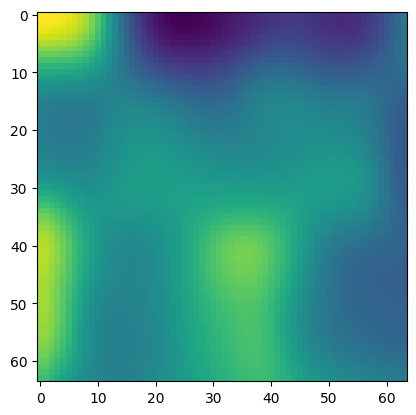

In [100]:
import matplotlib.pyplot as plt
sample = dataset[0]
x, y = sample["image"], sample["label"]

print(x.shape, x.dtype, x.min(), x.max())
print(y, dataset.classes[y])
plt.imshow(x[0])